# March Madness Bracket Prediction Data Crunch 2020 - Case Competition


Every year, The Center for Digital Transformation at Fordham and the Fordham Business Analytics Society hosted **March Data Crunch Madness** competition.

**What if you could use data analysis and machine learning techniques to optimize your pool by predicting the NCAA Basketball Tournament results?**

Even March Madness 2020 was cancelled due to COVID-19, the competition still went on. The competition is sponsored by Deloitte. 

Since there is no data for 2020, we use the 2002-2019 data for prediction and model building.

## Overview

Apply machine learning and statistical analysis to predict 2020 NCAA Men's Basketball game outcome and championship on seasonal performance, game seed, and other stats.

## Data Description

   - Training Data: 2002 - 2017
   - Testing Data: 2018
   - Application for prediction data: 2019


## What's new about this approach ?

- Instead of analyzing the stats of each team, engineer new features by transforming the features into **Difference** and **Ratio (Quotient)** between **two teams** in each of **63 games**


- Then calculated the **Winning Rate** and **Teamwork Score** for each team and coach, and predict probability, using machine learning models and logistic regression.  


    - Difference

$$ Difference = Team 1 Features N - Team 2 Features N $$

    - Ratio (Quotient) 



$$ Ratio = \frac {Team 1 Features N}{Team 2 Features N} $$

    - Winning Rate


$$ Winning Rate = \frac{Wins}{Wins + Losses} x 100 $$

    - Teamwork Score

$$ Teamwork Score = 0.8 x Team Arate + 0.2 x Team Adjde $$



- The level of teamwork can be reflected by the percentage of assist scored (arate) and the defensive efficiency (adjde), hence, the team can be more stable if they rely on assist better defense to win the game.

## Pipeline

### **`Data Preprocessing`**

- Replace missing values, Zero Checkups
- Clean data
- Shuffle data
    
    
###  **`Feature Engineering`**

Difference, Quotient, Winning Rate, and Teamwork Score between two teams


### **`Feature Selection`**

Apply Embedded method with **Random Forest** and **Statistical Methods** to select the most important features, resulted in 12 features :

   - Remove variables that are highly collerated with Pearson corr > 0.9 to avoid multicollinearity
   
   - Use Embedded methodology: apply Random Forest to find the most important variables
   
_Other method such as PCA components is tested but eliminated because the models generated higher log loss score when applying this approach rather than Random Forest. For further detail, go to Appendix section at the end of the notebook_

### **`Model Comparision`**

Applied and tested 5 models and find the model with the highest accuracy and the lowest log loss.

<img src="CLF_table.png" width=400>

### **`Model Selection`**

- Random Forest Classifier is selected based on the most optimal accuracy rate and log loss.

- Apply the model on the 2019 date to generate prediction and probability.


## Result

The accuracy of the best model Random Forest Classifier is **77.61%** with a log loss of 0.51

- Cross Validation Score (5-Fold): 0.7392
- F1 Score: 
        - Team 1 Wins: 0.73
        - Team 2 Wins: 0.76
        
## Which Teams Are The Final Four and Champion ?

<img src="Final Four Prediction.png" width=600>



- The percentages reflect the winning probability prediction for each team at the final four.
- **VIRGINIA** is predicted to be the final champion
____

## Data Preprocessing

In [10]:
# Import packages
#!pip install matplotlib
import numpy as np
import pandas as pd

from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    log_loss,
    auc,
    classification_report,
    roc_auc_score,
    roc_curve,         
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
# import raw data
data = pd.read_csv('NCAA_Tourney_2002_2019.csv')

- Split data

In [151]:
ncaa_df = data[data['season']!=2019].reset_index(drop=True)
test_2019 = data[data['season']==2019].reset_index(drop=True)

In [13]:
len(ncaa_df)

1100

In [16]:
# checking the columns in the dataset
print([i for i in ncaa_df.columns])                                       # list columns name
print("\nNumber of variables is {}".format(len(ncaa_df.columns)))         # Number of variables

['team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc', 'num_ot', 'team1_position', 'team2_position', 'team1_seed', 'team2_seed', 'strongseed', 'weakseed', 'team1_region', 'team2_region', 'slot', 'team1_teamname', 'team2_teamname', 'season', 'host', 'host_lat', 'host_long', 'team1_lat', 'team1_long', 'team2_lat', 'team2_long', 'team1_coach_id', 'team1_pt_school_ncaa', 'team1_pt_overall_ncaa', 'team1_pt_school_s16', 'team1_pt_overall_s16', 'team1_pt_school_ff', 'team1_pt_overall_ff', 'team1_pt_career_school_wins', 'team1_pt_career_school_losses', 'team1_pt_career_overall_wins', 'team1_pt_career_overall_losses', 'team1_pt_team_season_wins', 'team1_pt_team_season_losses', 'team1_pt_coach_season_wins', 'team1_pt_coach_season_losses', 'team2_coach_id', 'team2_pt_school_ncaa', 'team2_pt_overall_ncaa', 'team2_pt_school_s16', 'team2_pt_overall_s16', 'team2_pt_school_ff', 'team2_pt_overall_ff', 'team2_pt_career_school_wins', 'team2_pt_career_school_losses', 'team2_pt_career_overall_wins'

In [17]:
# Display all the columns and values in the dataframe 
pd.set_option("display.max_columns", None)
ncaa_df.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,strongseed,weakseed,team1_region,team2_region,slot,team1_teamname,team2_teamname,season,host,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id
0,1373.0,81,1108.0,77,N,0,W16b,W16a,16,16,16,16,W,W,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0,0.0,0.0,0.0,0.0,0.0,16.0,18.0,16.0,18.0,16.0,18.0,16.0,18.0,davey-whitney-1,6.0,6.0,0.0,0.0,0.0,0.0,317.0,210.0,317.0,210.0,20.0,9.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373.0-1108.0
1,1104.0,86,1194.0,78,N,0,Y02,Y15,2,15,2,15,Y,Y,R1Y2,Alabama,FL Atlantic,2002,greenville,35.6017,-77.3725,33.214400,-87.545766,26.372536,-80.102293,mark-gottfried-1,0.0,2.0,0.0,0.0,0.0,0.0,81.0,49.0,149.0,73.0,26.0,7.0,26.0,7.0,sidney-green-1,0.0,0.0,0.0,0.0,0.0,0.0,28.0,63.0,28.0,63.0,19.0,11.0,19.0,11.0,8.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,2002-1104.0-1194.0
2,1112.0,86,1364.0,81,N,0,Z03,Z14,3,14,3,14,Z,Z,R1Z3,Arizona,Santa Barbara,2002,albuquerque,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,lute-olson-1,17.0,22.0,8.0,10.0,4.0,5.0,467.0,144.0,656.0,239.0,22.0,9.0,22.0,9.0,bob-williams-1,0.0,0.0,0.0,0.0,0.0,0.0,62.0,52.0,62.0,52.0,20.0,10.0,20.0,10.0,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112.0-1364.0
3,1181.0,84,1457.0,37,N,0,Y01,Y16,1,16,1,16,Y,Y,R1Y1,Duke,Winthrop,2002,greenville,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,mike-krzyzewski-1,17.0,17.0,12.0,12.0,9.0,9.0,562.0,167.0,635.0,226.0,29.0,3.0,29.0,3.0,gregg-marshall-1,3.0,

In [18]:
# Exploratory Analysis: Understand statistic of each vairables
ncaa_df.describe()

,team1_id,team1_score,team2_id,team2_score,num_ot,team1_seed,team2_seed,strongseed,weakseed,season,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,755.000000,647.000000,759.000000,609.000000,400.000000,340.000000,379.000000,322.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,1295.463636,75.475455,1294.743636,64.029091,0.071818,5.110000,8.786364,3.873636,10.022727,2010.105455,37.995509,-92.357225,38.156939,-88.976510,37.946648,-90.155203,5.549091,8.697273,2.879091,4.180909,1.058182,1.463636,209.487273,84.182727,347.079091,153.591818,27.579091,7.601818,25.160909,7.083636,3.270000,5.389091,1.406364,2.117273,0.478182,0.671818,153.878182,78.685455,252.785455,135.540000,25.820909,8.880909,23.443636,8.580000,9.990728,9.828439,9.725955,9.638752,13.160000,12.585294,13.298153,12.493789,51.311592,36.437973,70.903780,11.135498,45.136104,32.792362,69.080831,8.358248,32.974779,33.057322,55.950519,51.721782,0.103681,0.088141,50.578791,35.996404,70.645615,10.247907,46.010131,33.234947,69.219057,8.524160,33.432692,33.281271,55.737353,52.096998,0.101265,0.090101,67.636575,67.318344,111.036499,112.965709,95.334406,93.932994,67.430561,67.148215,108.668283,109.671115,96.994895,96.397017
std,101.272960,10.723523,106.389826,10.416926,0.303642,3.952365,4.616779,3.036543,3.944154,4.910460,4.704917,14.609705,4.158212,13.023057,4.366819,13.929806,6.695261,7.627484,4.291783,4.927223,2.153415,2.487374,195.971635,65.623116,236.391596,92.208144,34.361061,7.215618,3.822556,3.056982,5.031367,6.297845,3.107910,3.709157,1.514407,1.744490,148.288205,61.135086,198.880180,89.669321,38.522859,5.56

Now, it's time to check which variables contain **NA values**

In [19]:
# Show all rows and values in the dataframe
pd.set_option('display.max_rows', None)
# NA check
ncaa_df.isna().sum()

team1_id                            0
team1_score                         0
team2_id                            0
team2_score                         0
WLoc                                0
num_ot                              0
team1_position                      0
team2_position                      0
team1_seed                          0
team2_seed                          0
strongseed                          0
weakseed                            0
team1_region                        0
team2_region                        0
slot                                0
team1_teamname                      0
team2_teamname                      0
season                              0
host                                0
host_lat                            0
host_long                           0
team1_lat                           0
team1_long                          0
team2_lat                           0
team2_long                          0
team1_coach_id                      0
team1_pt_sch

In [20]:
print("There are {} variables with missing values".format(len([i for i in ncaa_df.isna().sum() if i > 0])))

There are 8 variables with missing values


- team1_ap_final                    
- team1_ap_preseason                
- team1_coaches_before_final        
- team1_coaches_preseason           
- team2_ap_final                    
- team2_ap_preseason                
- team2_coaches_before_final        
- team2_coaches_preseason     

**Note**: 
**`These preseason AP Poll Ranking, final AP Poll Ranking, preseason Coaches Poll Ranking, and before final Coaches Poll Ranking are only available for TOP 25 teams and coaches, hence, there were not enough data for these variables.`**

Therefore, these variables range from **`1 to 25`** (min = 1, max = 25). 

To tackle this problem, the NA rankings will be **filled with a random ambiguous outlier** (value = 55) which is distinct from all other values.

In [21]:
ncaa_df.fillna(55.0, inplace = True)

Now we will double check if there is still NA values

In [22]:
print("There are {} variable with missing value".format(len([i for i in ncaa_df.isna().sum() if i > 0])))

There are 0 variable with missing value


Now, we will check if any variable contains **0 value**.

In [23]:
zero_check = [i for i in ncaa_df.columns if 0 in ncaa_df[i].values]   # Check if any variables contain 0
print("There are {} variables that include 0 value".format(len(zero_check)))
print("\nThese variables are\n{}".format(zero_check))

There are 23 variables that include 0 value

These variables are
['num_ot', 'team1_pt_school_ncaa', 'team1_pt_overall_ncaa', 'team1_pt_school_s16', 'team1_pt_overall_s16', 'team1_pt_school_ff', 'team1_pt_overall_ff', 'team1_pt_career_school_wins', 'team1_pt_career_overall_wins', 'team1_pt_team_season_losses', 'team1_pt_coach_season_wins', 'team1_pt_coach_season_losses', 'team2_pt_school_ncaa', 'team2_pt_overall_ncaa', 'team2_pt_school_s16', 'team2_pt_overall_s16', 'team2_pt_school_ff', 'team2_pt_overall_ff', 'team2_pt_career_school_wins', 'team2_pt_career_overall_wins', 'team2_pt_team_season_losses', 'team2_pt_coach_season_wins', 'team2_pt_coach_season_losses']


**Replace 0 with 0.0001** to avoid these 0 values being considered as NA in further statistical analysis. 

In [25]:
for i in zero_check:
    ncaa_df[i] = ncaa_df[i].astype(float).replace(0, 0.0001)

In [ ]:
#ncaa_df.season.value_counts()

## Shuffle & Split the dataset

### The dataset setup:

 - Ordered by Year (2002 - 2019) 
 
 - The Winning team is always assigned as Team 1
 
### Preprocess steps:

 - Shuffle the data randomly by year
 
 - Split the data in half by rows as:
 
 
 
     - First half: Team 1 as winning team
     - Second half: Team 2 as winning team

In [28]:
# Define a shuffle function
def shuffle(x):
    x = x.reindex(np.random.permutation(x.index)).copy()
    return x.reset_index(drop=True)

In [32]:
# Shuffle data
ncaa_df = shuffle(ncaa_df)

In [34]:
# Split the data in half
population = range(len(ncaa_df))    # Population range (0,1167)
k = round(len(ncaa_df)/2)           # k = 584 | half of the data

rnd = random.sample(population,k)
ncaa_team_1 = ncaa_df[ncaa_df.index.isin(rnd)].reset_index(drop=True)
ncaa_team_2 = ncaa_df[~ncaa_df.index.isin(rnd)].reset_index(drop=True)

print("Data shape for team 1 and team 2 as (Rows, Columns):\n###")
print ("Team 1 : {}".format(ncaa_team_1.shape))
print ("Team 2 : {}".format(ncaa_team_2.shape))

Data shape for team 1 and team 2 as (Rows, Columns):
###
Team 1 : (550, 104)
Team 2 : (550, 104)


In [36]:
# Rename team 1 and team 2
ncaa_team_2.columns=['team2_id', 'team2_score', 'team1_id', 'team1_score', 'WLoc',
       'num_ot', 'team2_position', 'team1_position', 'team2_seed',
       'team1_seed', 'strongseed', 'weakseed', 'team2_region',
       'team1_region', 'slot', 'team2_teamname', 'team1_teamname',
       'season', 'host', 'host_lat', 'host_long', 'team2_lat',
       'team2_long', 'team1_lat', 'team1_long', 'team2_coach_id',
       'team2_pt_school_ncaa', 'team2_pt_overall_ncaa',
       'team2_pt_school_s16', 'team2_pt_overall_s16',
       'team2_pt_school_ff', 'team2_pt_overall_ff',
       'team2_pt_career_school_wins', 'team2_pt_career_school_losses',
       'team2_pt_career_overall_wins', 'team2_pt_career_overall_losses',
       'team2_pt_team_season_wins', 'team2_pt_team_season_losses',
       'team2_pt_coach_season_wins', 'team2_pt_coach_season_losses',
       'team1_coach_id', 'team1_pt_school_ncaa', 'team1_pt_overall_ncaa',
       'team1_pt_school_s16', 'team1_pt_overall_s16',
       'team1_pt_school_ff', 'team1_pt_overall_ff',
       'team1_pt_career_school_wins', 'team1_pt_career_school_losses',
       'team1_pt_career_overall_wins', 'team1_pt_career_overall_losses',
       'team1_pt_team_season_wins', 'team1_pt_team_season_losses',
       'team1_pt_coach_season_wins', 'team1_pt_coach_season_losses',
       'team2_ap_final', 'team2_ap_preseason',
       'team2_coaches_before_final', 'team2_coaches_preseason',
       'team1_ap_final', 'team1_ap_preseason',
       'team1_coaches_before_final', 'team1_coaches_preseason',
       'team2_fg2pct', 'team2_fg3pct', 'team2_ftpct', 'team2_blockpct',
       'team2_oppfg2pct', 'team2_oppfg3pct', 'team2_oppftpct',
       'team2_oppblockpct', 'team2_f3grate', 'team2_oppf3grate',
       'team2_arate', 'team2_opparate', 'team2_stlrate',
       'team2_oppstlrate', 'team1_fg2pct', 'team1_fg3pct', 'team1_ftpct',
       'team1_blockpct', 'team1_oppfg2pct', 'team1_oppfg3pct',
       'team1_oppftpct', 'team1_oppblockpct', 'team1_f3grate',
       'team1_oppf3grate', 'team1_arate', 'team1_opparate',
       'team1_stlrate', 'team1_oppstlrate', 'team2_tempo',
       'team2_adjtempo', 'team2_oe', 'team2_adjoe', 'team2_de',
       'team2_adjde', 'team1_tempo', 'team1_adjtempo', 'team1_oe',
        'team1_adjoe', 'team1_de', 'team1_adjde', 'game_id']

In [37]:
# Switching the order of renamed columns so that it matches with the original dataframe
ncaa_team_2 = ncaa_team_2[['team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc',
       'num_ot', 'team1_position', 'team2_position', 'team1_seed',
       'team2_seed', 'strongseed', 'weakseed', 'team1_region',
       'team2_region', 'slot', 'team1_teamname', 'team2_teamname',
       'season', 'host', 'host_lat', 'host_long', 'team1_lat',
       'team1_long', 'team2_lat', 'team2_long', 'team1_coach_id',
       'team1_pt_school_ncaa', 'team1_pt_overall_ncaa',
       'team1_pt_school_s16', 'team1_pt_overall_s16',
       'team1_pt_school_ff', 'team1_pt_overall_ff',
       'team1_pt_career_school_wins', 'team1_pt_career_school_losses',
       'team1_pt_career_overall_wins', 'team1_pt_career_overall_losses',
       'team1_pt_team_season_wins', 'team1_pt_team_season_losses',
       'team1_pt_coach_season_wins', 'team1_pt_coach_season_losses',
       'team2_coach_id', 'team2_pt_school_ncaa', 'team2_pt_overall_ncaa',
       'team2_pt_school_s16', 'team2_pt_overall_s16',
       'team2_pt_school_ff', 'team2_pt_overall_ff',
       'team2_pt_career_school_wins', 'team2_pt_career_school_losses',
       'team2_pt_career_overall_wins', 'team2_pt_career_overall_losses',
       'team2_pt_team_season_wins', 'team2_pt_team_season_losses',
       'team2_pt_coach_season_wins', 'team2_pt_coach_season_losses',
       'team1_ap_final', 'team1_ap_preseason',
       'team1_coaches_before_final', 'team1_coaches_preseason',
       'team2_ap_final', 'team2_ap_preseason',
       'team2_coaches_before_final', 'team2_coaches_preseason',
       'team1_fg2pct', 'team1_fg3pct', 'team1_ftpct', 'team1_blockpct',
       'team1_oppfg2pct', 'team1_oppfg3pct', 'team1_oppftpct',
       'team1_oppblockpct', 'team1_f3grate', 'team1_oppf3grate',
       'team1_arate', 'team1_opparate', 'team1_stlrate',
       'team1_oppstlrate', 'team2_fg2pct', 'team2_fg3pct', 'team2_ftpct',
       'team2_blockpct', 'team2_oppfg2pct', 'team2_oppfg3pct',
       'team2_oppftpct', 'team2_oppblockpct', 'team2_f3grate',
       'team2_oppf3grate', 'team2_arate', 'team2_opparate',
       'team2_stlrate', 'team2_oppstlrate', 'team1_tempo',
       'team1_adjtempo', 'team1_oe', 'team1_adjoe', 'team1_de',
       'team1_adjde', 'team2_tempo', 'team2_adjtempo', 'team2_oe',
       'team2_adjoe', 'team2_de', 'team2_adjde', 'game_id']]

In [38]:
# Double check if the name for team 1 and team 2 is balance
print("Number of variables for team 1 is: {}".format(len([i for i in ncaa_team_2.columns.values if "team1" in str(i)])))
print("Number of variables for team 2 is: {}".format(len([i for i in ncaa_team_2.columns.values if "team2" in str(i)])))

Number of variables for team 1 is: 47
Number of variables for team 2 is: 47


 - Add new target variable
       - WIN: 1
       - LOSS: 0
 - Combine two split datasets

In [39]:
# Add new target variable
ncaa_team_1['target'] = 1   # WIN
ncaa_team_2['target'] = 0   # LOSS

# Combine 2 dataframes together
ncaa_preprocessed = pd.concat([ncaa_team_1, ncaa_team_2], ignore_index=True)
ncaa_preprocessed.head()

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,strongseed,weakseed,team1_region,team2_region,slot,team1_teamname,team2_teamname,season,host,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_coach_id,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_coach_id,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id,target
0,1448.0,76,1190.0,73,N,0.0001,W02,W15,2,15,2,15,W,W,R1W2,Wake Forest,ETSU,2003,tampa,27.9710,-82.4650,36.135301,-80.279004,36.301643,-82.366954,skip-prosser-1,1.0000,6.0000,0.0001,0.0001,0.0001,0.0001,45.0,18.0,210.0,96.0,24.0,5.0,24.0,5.0,ed-dechellis-1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,105.0,92.0,105.0,92.0,20.0,10.0,20.0,10.0,9.0,55.0,9.0,55.0,55.0,55.0,55.0,55.0,50.4105,34.1071,75.1538,12.1806,43.2709,33.4815,69.2699,8.5386,31.4961,36.5062,54.7826,50.6812,0.0924,0.1080,48.9985,34.7619,73.7822,12.1972,48.0368,35.4204,72.3549,10.0154,24.4470,31.8337,49.3606,60.9314,0.1378,0.1067,69.4923,69.0613,112.0079,114.4814,96.8368,95.4639,77.6720,76.2661,102.1313,100.2287,99.2431,99.6142,2003-1448.0-1190.0,1
1,1373.0,81,1108.0,77,N,0.0001,W16b,W16a,16,16,16,16,W,W,W16,Siena,Alcorn St,2002,dayton,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,rob-lanier-1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,16.0,18.0,16.0,18.0,16.0,18.0,16.0,18.0,davey-whitney-1,6.0000,6.0000,0.0001,0.0001,0.0001,0.0001,317.0,210.0,317.0,210.0,20.0,9.0,20.0,9.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373.0-1108.0,1
2,1436.0,60,1393.0,57,N,1.0000,Y13,Y04,13,4,4,13,Y,Y,R1Y4,Vermont,Syracuse,2005,worcester,42.2667,-71.8000,44.479262,-73.198128,43.037587,-76.135062,tom-brennan-1,2.0000,2.0000,0.0001,0.0001,0.0001,0.0001,263.0,275.0,309.0,333.0,24.0,6.0,24.0,6.0,jim-boeheim-1,23.0000,23.0000,12.0000,12.0000,3.0000,3.0000,703.0,240.0,703.0,240.0,27.0,6.0,27.0,6.0,55.0,55.0,55.0,55.0,16.0,6.0,13.0,6.0,48.6830,35.8189,72.1649,4.6414,45.6540,32.3680,70.0837,8.2652,40.5508,33.1264,61.3665,53.0780,0.1030,0.0944,54.2210,31.2000,66.6667,13.3051,43.1356,32.5974,67.7266,7.4811,25.5493,39.4872,55.1797,65.2632,0.1214,0.1056,65.5400,66.0115,111.0011,111.3507,94.3877,99.5523,66.8956,67.3664,112.5575,115.0698,96.8214,94.7440,2005-1436.0-1393.0,1
3,1181.0,93,1423.0,85,N,0.0001,Z04,Z13,4,13,4,13,Z,Z,R1Z4,Duke,UNC Wilmington,2016,providence,41.8236,-71.4

In [40]:
# Save preprocessed data to a csv file
ncaa_preprocessed.to_csv("preprocessed_ncaa.csv")

_______________
## Feature Engineering


- New Features:
 1. Distance between Host and Team's Location
     - Approximate the radius of earth in Km is 6378 km, according to [Goddard Space Flight Center](https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html)
     
 2. Difference & Quotient between the Team 1 & 2 variables

In [42]:
# Define a new data frame to store new features
ncaa = pd.DataFrame({"game_id": ncaa_preprocessed['game_id'],
                     "season": ncaa_preprocessed['season'],
                     "target": ncaa_preprocessed['target']}) 

In [43]:
# Define a function to calculate distance between the locations of host and team
def distance(lat_1, lon_1, lat_2, lon_2):
    
    # Approximate Radius of earth in Km
    Radius = 6378.0
    
    # Calculate distance between latitude
    lat_1 = radians(lat_1)
    lat_2 = radians(lat_2)
    distance_latitude = lat_2 - lat_1
    
    # Calculate distance between longitude
    lon_1 = radians(lon_1)
    lon_2 = radians(lon_2)
    distance_longitude = lon_2 - lon_1
    
    a = sin(distance_latitude/2)**2 + cos(lat_1) * cos(lat_2) * sin(distance_longitude/2)**2
    c = 2* atan2(sqrt(a), sqrt(1-a))
    
    distance = Radius* c
    
    return distance  

# Calculate distance between host and team 1
ncaa['distance_1'] = ncaa_preprocessed.apply(lambda row:distance(row['host_lat'],row['host_long'],
                                                                 row['team1_lat'],row['team1_long']),
                                                          axis=1)

# Calculate distance between host and team 2
ncaa['distance_2'] = ncaa_preprocessed.apply(lambda row:distance(row['host_lat'],row['host_long'],
                                                                 row['team2_lat'],row['team2_long']),
                                                          axis=1)

In [44]:
"""
     Engineer "difference" and "quotient" team features:
     
         Step 1: Extract & store a team 1 & 2 features (columns preprocessed name) into a dataframe:

         Step 2: Drop those features [index] that are not used in difference and quotient calculations:           
              - team id [0], team region [4], team name [5]
              - team lat [6], team long [7]
              - coach id [8]
          
         Step 3: Engineer diff and quotient features in the columns preprocessed dataframe
              - "diff_col": store diff feature names  [team 1 feature - team 2 feature] 
              - "quotient_col": store quotient feature names [team 1 feature / team 2 feature]
          
        Step 4: Calculate team 1 & team 2 features difference and quotient store them in "ncaa" DF
"""
# Step 1
col_preprocessed = pd.DataFrame({'team1_col':[i for i in ncaa_preprocessed.columns.values if "team1" in str(i)],
                                 'team2_col':[i for i in ncaa_preprocessed.columns.values if "team2" in str(i)]}) 
# Step 2
col_preprocessed = col_preprocessed.drop([0,1,4,5,6,7,8], axis=0).reset_index(drop=True) 

# Step 3
col_preprocessed['diff_col'] = [str(col_preprocessed.team2_col[i]).replace("team2","diff") 
                                for i in range(0,len(col_preprocessed))]
col_preprocessed['quotient_col'] = [str(col_preprocessed.team2_col[i]).replace("team2","quotient") 
                                    for i in range(0,len(col_preprocessed))]

# Step 4
team1_features = ncaa_preprocessed[col_preprocessed['team1_col']]    # Store team 1 features in a DF
team2_features = ncaa_preprocessed[col_preprocessed['team2_col']]    # Store team 2 features in a DF

for i in range(0, len(col_preprocessed)):
    if type(team1_features.iloc[0,i]) in (np.float64, np.int64):
        ncaa[col_preprocessed['diff_col'][i]] = team1_features.iloc[:,i] - team2_features.iloc[:,i]    # Difference 
        ncaa[col_preprocessed['quotient_col'][i]] = team1_features.iloc[:,i] / team2_features.iloc[:,i]   # Quotient


In [45]:
# winning rate
"""
Engineer "winning rate" features:
     
         Step 1: Extract & store win & loss features name into a dataframe
         Step 2: Engineer winning rate columns name and store it in the dataframe
         Step 3: Calculate winning rate features difference and quotient store them in "ncaa" DF
"""
# Step 1
wl_preprocessed = pd.DataFrame({'win_col': [i for i in ncaa_preprocessed.columns.values if "wins" in str(i)],
                                'loss_col': [i for i in ncaa_preprocessed.columns.values if "losses" in str(i)]})
# Step 2
wl_preprocessed['WL_col'] = [str(wl_preprocessed['loss_col'][i]).replace("losses","winning_rate") 
                             for i in range(0,len(wl_preprocessed))]
# Step 3
wins = ncaa_preprocessed[wl_preprocessed['win_col']]
losses = ncaa_preprocessed[wl_preprocessed['loss_col']]
    
for i in range(0,len(wl_preprocessed)):
    if type(wins.iloc[0,i]) in (np.float64, np.int64):
        ncaa[wl_preprocessed['WL_col'][i]] = wins.iloc[:,i]/(wins.iloc[:,i]+losses.iloc[:,i])

In [181]:
# teamwork ability
ncaa['teamwork_score_1'] = ncaa_preprocessed['team1_arate']*0.8 + ncaa_preprocessed['team1_adjde']*0.2
ncaa['teamwork_score_2'] = ncaa_preprocessed['team2_arate']*0.8 + ncaa_preprocessed['team2_adjde']*0.2

In [182]:
pd.set_option("display.max_columns", None) # Show all columns in features table
ncaa.head()

,game_id,season,target,distance_1,distance_2,diff_seed,quotient_seed,diff_pt_school_ncaa,quotient_pt_school_ncaa,diff_pt_overall_ncaa,quotient_pt_overall_ncaa,diff_pt_school_s16,quotient_pt_school_s16,diff_pt_overall_s16,quotient_pt_overall_s16,diff_pt_school_ff,quotient_pt_school_ff,diff_pt_overall_ff,quotient_pt_overall_ff,diff_pt_career_school_wins,quotient_pt_career_school_wins,diff_pt_career_school_losses,quotient_pt_career_school_losses,diff_pt_career_overall_wins,quotient_pt_career_overall_wins,diff_pt_career_overall_losses,quotient_pt_career_overall_losses,diff_pt_team_season_wins,quotient_pt_team_season_wins,diff_pt_team_season_losses,quotient_pt_team_season_losses,diff_pt_coach_season_wins,quotient_pt_coach_season_wins,diff_pt_coach_season_losses,quotient_pt_coach_season_losses,diff_ap_final,quotient_ap_final,diff_ap_preseason,quotient_ap_preseason,diff_coaches_before_final,quotient_coaches_before_final,diff_coaches_preseason,quotient_coaches_preseason,diff_fg2pct,quotient_fg2pct,diff_fg3pct,quotient_fg3pct,diff_ftpct,quotient_ftpct,diff_blockpct,quotient_blockpct,diff_oppfg2pct,quotient_oppfg2pct,diff_oppfg3pct,quotient_oppfg3pct,diff_oppftpct,quotient_oppftpct,diff_oppblockpct,quotient_oppblockpct,diff_f3grate,quotient_f3grate,diff_oppf3grate,quotient_oppf3grate,diff_arate,quotient_arate,diff_opparate,quotient_opparate,diff_stlrate,quotient_stlrate,diff_oppstlrate,quotient_oppstlrate,diff_tempo,quotient_tempo,diff_adjtempo,quotient_adjtempo,diff_oe,quotient_oe,diff_adjoe,quotient_adjoe,diff_de,quotient_de,diff_adjde,quotient_adjde,team1_pt_career_school_winning_rate,team1_pt_career_overall_winning_rate,team1_pt_team_season_winning_rate,team1_pt_coach_season_winning_rate,team2_pt_career_school_winning_rate,team2_pt_career_overall_winning_rate,team2_pt_team_season_winning_rate,team2_pt_coach_season_winning_rate,teamwork_score_1,teamwork_score_2
0,2003-1448.0-1190.0,2003,1,931.849386,927.388892,-13,0.133333,0.9999,10000.000000,5.9999,60000.000000,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,-60.0,0.428571,-74.0,0.195652,105.0,2.000000,4.0,1.043478,4.0,1.200000,-5.0,0.500000,4.0,1.200000,-5.0,0.500000,-46.0,0.163636,0.0,1.000000,-46.0,0.163636,0.0,1.000000,1.4120,1.028817,-0.6548,0.981163,1.3716,1.018590,-0.0166,0.998639,-4.7659,0.900786,-1.9389,0.945260,-3.0850,0.957363,-1.4768,0.852547,7.0491,1.288342,4.6725,1.146778,5.4220,1.109845,-10.2502,0.831775,-0.0454,0.670537,0.0013,1.012184,-8.1797,0.894689,-7.2048,0.905531,9.8766,1.096705,14.2527,1.142202,-2.4063,0.975753,-4.1503,0.958336,0.714286,0.686275,0.827586,0.827586,0.532995,0.532995,0.666667,0.666667,62.91886,59.41132
1,2002-1373.0-1108.0,2002,1,933.140832,1077.865606,0,1.000000,-5.9999,0.000017,-5.9999,0.000017,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,-301.0,0.050473,-192.0,0.085714,-301.0,0.050473,-192.0,0.085714,-4.0,0.800000,9.0,2.000000,-4.0,0.800000,9.0,2.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,-3.3011,0.932512,-2.9296,0.921993,10.1927,1.158739,1.8968,1.201060,-5.0365,0.894409,-0.4672,0.986302,-1.0034,0.985798,4.0673,1.630873,11.3485,1.473359,6.9488,1.233902,0.1882,1.003464,1.0296,1.018106,-0.0302,0.720370,-0.0029,0.972355,-7.2239,0.905032,-6.1145,0.917204,-4.7283,0.954281,-1.2563,0.987420,-3.2682,0.967199,-6.7615,0.936482,0.470588,0.470588,0.470588,0.470588,0.601518,0.601518,0.689655,0.689655,63.54850,64.75024
2,2005-1436.0-1393.0,2005,1,271.024438,365.098065,9,3.250000,-21.0000,0.086957,-21.0000,0.086957,-11.9999,0.000008,-11.9999,0.000008,-2.9999,0.000033,-2.9999,0.000033,-440.0,0.374111,35.0,1.145833,-394.0,0.439545,93.0,1.387500,-3.0,0.888889,0.0,1.000000,-3.0,0.888889,0.0,1.000000,39.0,3.437500,49.0,9.166667,42.0,4.230769,49.0,9.166667,-5.5380,0.897862,4.6189,1.148042,5.4982,1.082473,-8.6637,0.348844,2.5184,1.058383,-0.2294,0.992963,2.3571,1.034803,0.7841,1.104811,15.0015,1.587159,-6.3608,0.838915,6.1868,1.112121,-12.1852,0.813291,-0.0184,0.848435,-0.0112,0.893939,-1.3556,0.979736,-1.3549,0.97

In [183]:
len(ncaa.columns.values)

93

## Feature Selection

- Caculate correlations between these variables
- Remove variables with correlation larger than 0.9 and smaller than -0.9
- Remove variables with 

In [184]:
# Drop game ID and target because game ID is unique identifier and target is the method
corr_variables = ncaa.drop(columns=['game_id','target','season'])

In [185]:
corr_variables.head()

,distance_1,distance_2,diff_seed,quotient_seed,diff_pt_school_ncaa,quotient_pt_school_ncaa,diff_pt_overall_ncaa,quotient_pt_overall_ncaa,diff_pt_school_s16,quotient_pt_school_s16,diff_pt_overall_s16,quotient_pt_overall_s16,diff_pt_school_ff,quotient_pt_school_ff,diff_pt_overall_ff,quotient_pt_overall_ff,diff_pt_career_school_wins,quotient_pt_career_school_wins,diff_pt_career_school_losses,quotient_pt_career_school_losses,diff_pt_career_overall_wins,quotient_pt_career_overall_wins,diff_pt_career_overall_losses,quotient_pt_career_overall_losses,diff_pt_team_season_wins,quotient_pt_team_season_wins,diff_pt_team_season_losses,quotient_pt_team_season_losses,diff_pt_coach_season_wins,quotient_pt_coach_season_wins,diff_pt_coach_season_losses,quotient_pt_coach_season_losses,diff_ap_final,quotient_ap_final,diff_ap_preseason,quotient_ap_preseason,diff_coaches_before_final,quotient_coaches_before_final,diff_coaches_preseason,quotient_coaches_preseason,diff_fg2pct,quotient_fg2pct,diff_fg3pct,quotient_fg3pct,diff_ftpct,quotient_ftpct,diff_blockpct,quotient_blockpct,diff_oppfg2pct,quotient_oppfg2pct,diff_oppfg3pct,quotient_oppfg3pct,diff_oppftpct,quotient_oppftpct,diff_oppblockpct,quotient_oppblockpct,diff_f3grate,quotient_f3grate,diff_oppf3grate,quotient_oppf3grate,diff_arate,quotient_arate,diff_opparate,quotient_opparate,diff_stlrate,quotient_stlrate,diff_oppstlrate,quotient_oppstlrate,diff_tempo,quotient_tempo,diff_adjtempo,quotient_adjtempo,diff_oe,quotient_oe,diff_adjoe,quotient_adjoe,diff_de,quotient_de,diff_adjde,quotient_adjde,team1_pt_career_school_winning_rate,team1_pt_career_overall_winning_rate,team1_pt_team_season_winning_rate,team1_pt_coach_season_winning_rate,team2_pt_career_school_winning_rate,team2_pt_career_overall_winning_rate,team2_pt_team_season_winning_rate,team2_pt_coach_season_winning_rate,teamwork_score_1,teamwork_score_2
0,931.849386,927.388892,-13,0.133333,0.9999,10000.000000,5.9999,60000.000000,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,-60.0,0.428571,-74.0,0.195652,105.0,2.000000,4.0,1.043478,4.0,1.200000,-5.0,0.500000,4.0,1.200000,-5.0,0.500000,-46.0,0.163636,0.0,1.000000,-46.0,0.163636,0.0,1.000000,1.4120,1.028817,-0.6548,0.981163,1.3716,1.018590,-0.0166,0.998639,-4.7659,0.900786,-1.9389,0.945260,-3.0850,0.957363,-1.4768,0.852547,7.0491,1.288342,4.6725,1.146778,5.4220,1.109845,-10.2502,0.831775,-0.0454,0.670537,0.0013,1.012184,-8.1797,0.894689,-7.2048,0.905531,9.8766,1.096705,14.2527,1.142202,-2.4063,0.975753,-4.1503,0.958336,0.714286,0.686275,0.827586,0.827586,0.532995,0.532995,0.666667,0.666667,62.91886,59.41132
1,933.140832,1077.865606,0,1.000000,-5.9999,0.000017,-5.9999,0.000017,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,0.0000,1.000000,-301.0,0.050473,-192.0,0.085714,-301.0,0.050473,-192.0,0.085714,-4.0,0.800000,9.0,2.000000,-4.0,0.800000,9.0,2.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,-3.3011,0.932512,-2.9296,0.921993,10.1927,1.158739,1.8968,1.201060,-5.0365,0.894409,-0.4672,0.986302,-1.0034,0.985798,4.0673,1.630873,11.3485,1.473359,6.9488,1.233902,0.1882,1.003464,1.0296,1.018106,-0.0302,0.720370,-0.0029,0.972355,-7.2239,0.905032,-6.1145,0.917204,-4.7283,0.954281,-1.2563,0.987420,-3.2682,0.967199,-6.7615,0.936482,0.470588,0.470588,0.470588,0.470588,0.601518,0.601518,0.689655,0.689655,63.54850,64.75024
2,271.024438,365.098065,9,3.250000,-21.0000,0.086957,-21.0000,0.086957,-11.9999,0.000008,-11.9999,0.000008,-2.9999,0.000033,-2.9999,0.000033,-440.0,0.374111,35.0,1.145833,-394.0,0.439545,93.0,1.387500,-3.0,0.888889,0.0,1.000000,-3.0,0.888889,0.0,1.000000,39.0,3.437500,49.0,9.166667,42.0,4.230769,49.0,9.166667,-5.5380,0.897862,4.6189,1.148042,5.4982,1.082473,-8.6637,0.348844,2.5184,1.058383,-0.2294,0.992963,2.3571,1.034803,0.7841,1.104811,15.0015,1.587159,-6.3608,0.838915,6.1868,1.112121,-12.1852,0.813291,-0.0184,0.848435,-0.0112,0.893939,-1.3556,0.979736,-1.3549,0.979888,-1.5564,0.986172,-3.7191,0.967680,-2.4337,0.974864,4.8083,1.050750,0.488848,0.481308,0.800000,0

In [186]:
correlation = corr_variables.corr()
correlation.style.background_gradient(cmap='coolwarm')

In [187]:
# Save correlation data to csv file
correlation.to_csv('marchmadness_corr2.csv')

Remove **35** highly correlated variables (corr > 0.9) to avoid highly collinearity and multilcolinearity.

"diff_pt_school_s16",
"diff_pt_overall_s16",
"diff_pt_overall_ff",
"diff_pt_career_school_wins",
"diff_pt_career_overall_wins",
"quotient_pt_career_overall_wins",
"quotient_pt_coach_season_losses",
"diff_ap_final",
"diff_coaches_preseason",
"quotient_coaches_preseason",
"quotient_fg2pct",
"quotient_fg3pct",
"quotient_ftpct",
"quotient_blockpct",
"quotient_oppfg2pct",
"quotient_oppfg3pct",
"quotient_oppftpct",
"quotient_oppblockpct",
"quotient_f3grate",
"quotient_oppf3grate",
"quotient_arate",
"quotient_opparate",
"quotient_stlrate",
"quotient_oppstlrate",
"quotient_tempo",
"diff_adjtempo",
"quotient_adjtempo",
"quotient_oe",
"diff_adjoe",
"quotient_adjoe",
"quotient_de",
"quotient_adjde",
"team1_pt_team_season_winning_rate",
"team1_pt_coach_season_winning_rate",
"team2_pt_coach_season_winning_rate",


**Note**: **`Collinearity & multilcolinearity inflate the variance of at least one or more estimated regression coefficient, which can cause at least some regression coef- ficients to have the wrong sign.`**  

In [188]:
removed_features = ["diff_pt_school_s16",
"diff_pt_overall_s16",
"diff_pt_overall_ff",
"diff_pt_career_school_wins",
"diff_pt_career_overall_wins",
"quotient_pt_career_overall_wins",
"quotient_pt_coach_season_losses",
"diff_ap_final",
"diff_coaches_preseason",
"quotient_coaches_preseason",
"quotient_fg2pct",
"quotient_fg3pct",
"quotient_ftpct",
"quotient_blockpct",
"quotient_oppfg2pct",
"quotient_oppfg3pct",
"quotient_oppftpct",
"quotient_oppblockpct",
"quotient_f3grate",
"quotient_oppf3grate",
"quotient_arate",
"quotient_opparate",
"quotient_stlrate",
"quotient_oppstlrate",
"quotient_tempo",
"diff_adjtempo",
"quotient_adjtempo",
"quotient_oe",
"diff_adjoe",
"quotient_adjoe",
"quotient_de",
"quotient_adjde",
"team1_pt_team_season_winning_rate",
"team1_pt_coach_season_winning_rate",
"team2_pt_coach_season_winning_rate"

]


ncaa_new = ncaa.drop(columns=removed_features, axis=1) # Drop highly correlated features

In [189]:
train = ncaa_new[ncaa_new['season']!=2018]
train.head()

,game_id,season,target,distance_1,distance_2,diff_seed,quotient_seed,diff_pt_school_ncaa,quotient_pt_school_ncaa,diff_pt_overall_ncaa,quotient_pt_overall_ncaa,quotient_pt_school_s16,quotient_pt_overall_s16,diff_pt_school_ff,quotient_pt_school_ff,quotient_pt_overall_ff,quotient_pt_career_school_wins,diff_pt_career_school_losses,quotient_pt_career_school_losses,diff_pt_career_overall_losses,quotient_pt_career_overall_losses,diff_pt_team_season_wins,quotient_pt_team_season_wins,diff_pt_team_season_losses,quotient_pt_team_season_losses,diff_pt_coach_season_wins,quotient_pt_coach_season_wins,diff_pt_coach_season_losses,quotient_ap_final,diff_ap_preseason,quotient_ap_preseason,diff_coaches_before_final,quotient_coaches_before_final,diff_fg2pct,diff_fg3pct,diff_ftpct,diff_blockpct,diff_oppfg2pct,diff_oppfg3pct,diff_oppftpct,diff_oppblockpct,diff_f3grate,diff_oppf3grate,diff_arate,diff_opparate,diff_stlrate,diff_oppstlrate,diff_tempo,diff_oe,diff_de,diff_adjde,team1_pt_career_school_winning_rate,team1_pt_career_overall_winning_rate,team2_pt_career_school_winning_rate,team2_pt_career_overall_winning_rate,team2_pt_team_season_winning_rate,teamwork_score_1,teamwork_score_2
0,2003-1448.0-1190.0,2003,1,931.849386,927.388892,-13,0.133333,0.9999,10000.000000,5.9999,60000.000000,1.000000,1.000000,0.0000,1.000000,1.000000,0.428571,-74.0,0.195652,4.0,1.043478,4.0,1.200000,-5.0,0.500000,4.0,1.200000,-5.0,0.163636,0.0,1.000000,-46.0,0.163636,1.4120,-0.6548,1.3716,-0.0166,-4.7659,-1.9389,-3.0850,-1.4768,7.0491,4.6725,5.4220,-10.2502,-0.0454,0.0013,-8.1797,9.8766,-2.4063,-4.1503,0.714286,0.686275,0.532995,0.532995,0.666667,62.91886,59.41132
1,2002-1373.0-1108.0,2002,1,933.140832,1077.865606,0,1.000000,-5.9999,0.000017,-5.9999,0.000017,1.000000,1.000000,0.0000,1.000000,1.000000,0.050473,-192.0,0.085714,-192.0,0.085714,-4.0,0.800000,9.0,2.000000,-4.0,0.800000,9.0,1.000000,0.0,1.000000,0.0,1.000000,-3.3011,-2.9296,10.1927,1.8968,-5.0365,-0.4672,-1.0034,4.0673,11.3485,6.9488,0.1882,1.0296,-0.0302,-0.0029,-7.2239,-4.7283,-3.2682,-6.7615,0.470588,0.470588,0.601518,0.601518,0.689655,63.54850,64.75024
2,2005-1436.0-1393.0,2005,1,271.024438,365.098065,9,3.250000,-21.0000,0.086957,-21.0000,0.086957,0.000008,0.000008,-2.9999,0.000033,0.000033,0.374111,35.0,1.145833,93.0,1.387500,-3.0,0.888889,0.0,1.000000,-3.0,0.888889,0.0,3.437500,49.0,9.166667,42.0,4.230769,-5.5380,4.6189,5.4982,-8.6637,2.5184,-0.2294,2.3571,0.7841,15.0015,-6.3608,6.1868,-12.1852,-0.0184,-0.0112,-1.3556,-1.5564,-2.4337,4.8083,0.488848,0.481308,0.745493,0.745493,0.818182,69.00366,63.09256
3,2016-1181.0-1423.0,2016,1,918.134111,1016.956193,-9,0.307692,30.9999,310000.000000,30.9999,310000.000000,220000.000000,220000.000000,11.9999,120000.000000,120000.000000,22.511628,240.0,12.428571,299.0,15.238095,-2.0,0.920000,3.0,1.428571,-2.0,0.920000,3.0,0.345455,-50.0,0.090909,0.0,1.000000,-0.5078,4.5906,1.8575,-1.2969,3.3549,-0.2299,-2.3143,1.6304,6.7056,0.4208,1.6264,5.3165,-0.0039,-0.0041,-2.1265,8.9990,4.5130,-1.0857,0.787632,0.764879,0.671875,0.671875,0.781250,59.10250,58.01852
4,2014-1124.0-1304.0,2014,1,271.510458,1280.058142,-5,0.545455,2.9999,30000.000000,2.0000,3.000000,20000.000000,20000.000000,0.0000,1.000000,1.000000,6.000000,119.0,4.966667,22.0,1.159420,5.0,1.263158,-1.0,0.916667,5.0,1.263158,-1.0,1.000000,-30.0,0.454545,-37.0,0.327273,0.8994,4.6990,-3.6959,4.7970,-1.3313,4.0401,-1.1769,-0.9033,0.7784,-2.8151,15.8090,10.7989,-0.0280,0.0013,-1.3823,11.6502,6.4919,5.9925,0.577904,0.583333,0.531250,0.505376,0.612903,66.87644,53.03074


In [190]:
len(removed_features)

35

In [191]:
# Drop season, target, and game id
X_train_sel = train.drop(['target','game_id','season'],axis=1)
y_train_sel = train['target']

Embedded methods: Apply **Random Forest** to select features  

**Why Random Forest to select Feature ?**

- Random forest comes under the category of Embedded methods, which combine the qualities of filter and wrapper methods. Some of the advantages are:
         - highly accurate
         - generalize better
         - interpretable (based on importance)
         
- Features are selected at the top of the tree will be more important than features that selected at the end of the tree. It works well when dealing with high-dimensional dataset (with various features)

In [192]:
# Feature selection using Random Forest
# Import libabries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Select features based on trainning data set to avoid over fitting
# n_estimator indicates the number of trees 
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000))
sel.fit(X_train_sel,y_train_sel)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False

In [222]:
# sel.get_support() shows which features are important
selected_features = X_train_sel.columns[(sel.get_support())]
print("\n{} selected features: \n{}\n".format(len(selected_features),set(selected_features)))


10 selected features: 
{'quotient_ap_final', 'diff_ap_preseason', 'quotient_ap_preseason', 'quotient_pt_team_season_wins', 'diff_oe', 'quotient_seed', 'quotient_coaches_before_final', 'diff_seed', 'diff_adjde', 'diff_coaches_before_final'}



In [223]:
ncaa_sel = ncaa_new[selected_features]
ncaa_sel['target'] = ncaa_new['target']
ncaa_sel['season'] = ncaa_new['season']
ncaa_sel['game_id'] = ncaa_new['game_id']

C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [224]:
ncaa_sel.to_csv('MM_FE_data.csv')

In [225]:
# Split train test data
train = ncaa_sel[ncaa_sel['season'] != 2018].reset_index(drop=True)
test = ncaa_sel[ncaa_sel['season']==2018].reset_index(drop=True)

X_train = train[selected_features]
y_train = train['target']
X_test = test[selected_features]
y_test = test['target']

## Model Building

- Model: **`Random Forest`**

- Hyperparameter tunning with **`Grid Search`**

     - n_estimators: number of trees
     - max_features: number of features considered for splitting at each leaf
     - max_dept: max number of levels in each decision tree
     - min_samples_split: min number of data points placed in a node before the node is split
     - min_samples_leaf = min number of data points allowed in a leaf node
     - bootstrap = method for sampling data points (with or without replacement)
   

In [226]:
rf = RandomForestClassifier()

from pprint import pprint

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [227]:
n_estimators = [50,100,300,1000]
max_depth = [2,5,8,10]
random_state = [None,10,30,42]
min_samples_split = [2,10,15,100]
min_samples_leaf = [1,2,5,10]

param_grid = dict(n_estimators = n_estimators,
                  random_state = random_state,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)
gridF = GridSearchCV(rf, param_grid, cv=5, verbose=1, n_jobs=-1)
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed:  9.7min finished


In [72]:
print("Best parameters for Random Forest :\n {}".format(gridF.best_params_))
print("\nBest accuracy score : {}".format(gridF.best_score_))

Best parameters for Random Forest :
 {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': None}

Best accuracy score : 0.7366915247877679


In [228]:
# Set up model
lr = LogisticRegression(random_state=42,
                       solver='liblinear',
                       multi_class='ovr')
GBC = GradientBoostingClassifier(n_estimators=10,
                                max_depth=1)
svc = SVC(probability=True)
rf = RandomForestClassifier(n_estimators=100,
                            max_depth = 5,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            random_state = None)
lda = LinearDiscriminantAnalysis()

# Names of the model
names  = ["Logistic Regression",
          "Gradient Boosting",
          "Support Vector Classifier",
          "Random Forest Classifier",
          "Linear Discriminant Analysis"]

# Store model in classifier
classifiers = [lr,GBC,svc,rf,lda]

# Set up a dataframe for Classifier result
CLF_df = pd.DataFrame({"Model":[],
                       "Accuracy Score":[],
                       "Log Loss":[]})
clf_model = []
clf_accuracy = []
clf_logloss = []
for name, model in zip(names,classifiers):
    clf = model.fit(X_train, y_train)
    test['pred'] = model.predict(X_test)
    clf_model.append(str(name))
    clf_accuracy.append(accuracy_score(test['target'],model.predict(X_test)))
    clf_logloss.append(log_loss(y_test,model.predict_proba(X_test)))
    
# Set up table result
CLF_df = pd.DataFrame({"Model":clf_model,
                       "Accuracy Score":clf_accuracy,
                       "Log Loss":clf_logloss})
CLF_df

,Model,Accuracy Score,Log Loss
0,Logistic Regression,0.761194,0.541972
1,Gradient Boosting,0.761194,0.545979
2,Support Vector Classifier,0.761194,0.552120
3,Random Forest Classifier,0.805970,0.500468
4,Linear Discriminant Analysis,0.746269,0.532933


**`Random Forest`** is selected as the best classifier based on the highest **accuracy score (0.77)** and the lowest **logloss (0.51)**. 

_As the outcome of preprocessing, the data is evenly divided into Team 1 wins as 1 Team 2 wins as 0. Therefore, accuracy score should be sufficient for model evaluation and there is no need to look at precision score and recall score for every model._ 

## Model Evaluation: Random Forest

 - Calculate precision, recall, F1 Scores of Random Forest
 - Plot Confusion Matrix of Random Forest
 
 
### 1. Precision, Recall, F1 Scores

In [229]:
from sklearn.metrics import roc_auc_score
rf_auc_score = roc_auc_score(y_test, model.predict(X_test))
print("\n ------ RANDOM FOREST CLASSIFIER ------\n")
print("AUC Score = %2.2f" % rf_auc_score)
print("\nRandom Forest Classifier Report :\n{}".format(classification_report(y_test, 
                                                                 model.predict(X_test))))


 ------ RANDOM FOREST CLASSIFIER ------

AUC Score = 0.76

Random Forest Classifier Report :
              precision    recall  f1-score   support

           0       0.84      0.69      0.76        39
           1       0.66      0.82      0.73        28

    accuracy                           0.75        67
   macro avg       0.75      0.76      0.75        67
weighted avg       0.77      0.75      0.75        67



### 2. Confusion Matrix

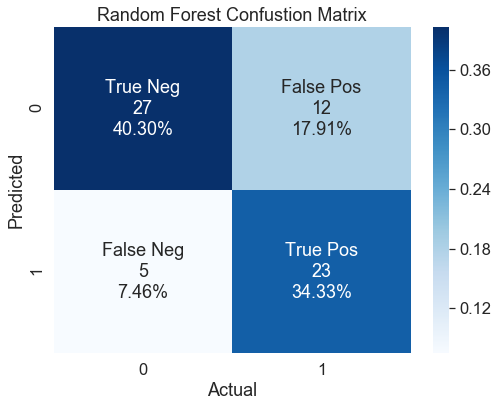

In [230]:
#!pip install matplotlib==3.1.2
# Create labels
fig, ax = plt.subplots()
cf_matrix = (confusion_matrix(y_test, model.predict(X_test)))

# Create labels for confusion matrix
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) 
                for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) 
                    for value in cf_matrix.flatten()/np.sum(cf_matrix)]

# combine all the labels
labels = [f"{v1}\n{v2}\n{v3}" 
          for v1, v2 ,v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# Set up theme for plot
sns.set(rc={'figure.figsize':(8,6)},
       font_scale=1.5)

# Plot confusion matrix
fig = sns.heatmap(cf_matrix/np.sum(cf_matrix),
            annot=labels,
            fmt='',
           cmap='Blues')
fig.set_title("Random Forest Confustion Matrix")
fig.set(xlabel = "Actual", ylabel="Predicted")

# Fix broken heat map annotation by seaborn
bottom,top = fig.get_ylim()  
fig.set_ylim(bottom + 0.5, top - 0.5);

According to the confusion matrix, accurate predictions account for 75% of the outcomes.  

Now, we will train Random Forest Classifer again by applying 5-fold Cross Validation.

## Cross Validation (5-Fold) | Random Forest

In [231]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth = 10,
                            min_samples_leaf = 2,
                            min_samples_split = 15,
                            random_state = 30)
rf_cv = cross_val_score(rf, X_train, y_train,cv=5, scoring='f1')
rf_cv.mean()

0.735934321637657

## Model Application into 2019 Data

Now, we will test the model on testing data.

_The data is sampled by Deloitte. Due to the incident of COVID-19, 2020 March Madness is cancelled. However, the passion for data science and analytics fueled us to join and excel at the competition. We built model on stimulated data and believed we can use the model for our 2021 March Madness prediction_

In [232]:
# Clean 2019 data
test_2019.fillna(55.0, inplace=True)
zero_check_2019 = [i for i in test_2019.columns if 0 in test_2019[i].values]
for i in zero_check_2019:
    test_2019[i] = test_2019[i].astype(float).replace(0,0.0001)

In [233]:
df_2019_selected = pd.DataFrame()

In [239]:
selected_features

Index(['diff_seed', 'quotient_seed', 'quotient_pt_team_season_wins',
       'quotient_ap_final', 'diff_ap_preseason', 'quotient_ap_preseason',
       'diff_coaches_before_final', 'quotient_coaches_before_final', 'diff_oe',
       'diff_adjde'],
      dtype='object')

In [241]:
# Engineer features for test data
team1_features_2019 = test_2019[col_preprocessed['team1_col']]    # Store team 1 features in a DF
team2_features_2019 = test_2019[col_preprocessed['team2_col']]    # Store team 2 features in a DF

for i in range(0, len(col_preprocessed)):
    if type(team1_features_2019.iloc[0,i]) in (np.float64, np.int64):
        df_2019_selected[col_preprocessed['diff_col'][i]] = team1_features_2019.iloc[:,i] - team2_features_2019.iloc[:,i]    # Difference 
        df_2019_selected[col_preprocessed['quotient_col'][i]] = team1_features_2019.iloc[:,i] / team2_features_2019.iloc[:,i]   # Quotient

df_2019_features = df_2019_selected[selected_features]

In [242]:
df_2019_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 10 columns):
diff_seed                        67 non-null int64
quotient_seed                    67 non-null float64
quotient_pt_team_season_wins     67 non-null float64
quotient_ap_final                67 non-null float64
diff_ap_preseason                67 non-null float64
quotient_ap_preseason            67 non-null float64
diff_coaches_before_final        67 non-null float64
quotient_coaches_before_final    67 non-null float64
diff_oe                          67 non-null float64
diff_adjde                       67 non-null float64
dtypes: float64(9), int64(1)
memory usage: 5.4 KB


In [254]:
prediction_result = pd.DataFrame({"game_id": df_2019['game_id'],
                                  "team1_id": df_2019['team1_id'],
                                  "team2_id": df_2019['team2_id']})
prediction_result['prediction'] = model.predict(df_2019_features)
prediction_result['probability'] = model.predict_proba(df_2019_features)[:,1]
prediction_result[['game_id','team1_teamname','team2_teamname']] = df_2019[['game_id','team1_teamname','team2_teamname']]

In [256]:
prediction_result = prediction_result.sort_values(by='probability', ascending=False)

In [246]:
# Save prediction result to csv files
prediction_result.to_csv("prediction_result.csv")

In [257]:
prediction_result

,game_id,team1_id,team2_id,prediction,probability,team1_teamname,team2_teamname
16,2019-1211.0-1192.0,1211.0,1192.0,1,0.934356,Gonzaga,F Dickinson
25,2019-1438.0-1205.0,1438.0,1205.0,1,0.916824,Virginia,Gardner Webb
24,2019-1181.0-1295.0,1181.0,1295.0,1,0.911292,Duke,N Dakota St
26,2019-1314.0-1233.0,1314.0,1233.0,1,0.889907,North Carolina,Iona
15,2019-1277.0-1133.0,1277.0,1133.0,1,0.882340,Michigan St,Bradley
36,2019-1211.0-1124.0,1211.0,1124.0,1,0.865857,Gonzaga,Baylor
48,2019-1438.0-1328.0,1438.0,1328.0,1,0.857328,Virginia,Oklahoma
27,2019-1397.0-1159.0,1397.0,1159.0,1,0.836445,Tennessee,Colgate
14,2019-1246.0-1101.0,1246.0,1101.0,1,0.836313,Kentucky,Abilene Chr
37,2019-1277.0-1278.0,1277.0,1278.0,1,0.813582,Michigan St,Minnesota


In [252]:
prediction_result[prediction_result.probability > 0.5].team1_teamname.value_counts()

Virginia          6
Duke              3
Michigan St       3
Gonzaga           3
Kentucky          3
Florida St        2
Texas Tech        2
Oregon            2
LSU               2
Michigan          2
North Carolina    2
Virginia Tech     2
Houston           2
Tennessee         2
Purdue            2
Belmont           1
N Dakota St       1
Auburn            1
Buffalo           1
Villanova         1
Kansas            1
Wofford           1
Arizona St        1
Name: team1_teamname, dtype: int64

# Appendix

## PCA Principal Approach Trial

PCA principal approach selection do not perform as well as Random Forest feature selection. The log loss for each models using PCA is significantly higher than the the log loss for each model using Random Forest. 

Therefore, this approach will not be chosen.

In [213]:
# PCA approach for features selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import  StandardScaler

x = ncaa_new.drop(['target','game_id','season'],axis=1).values  # Seperate out features
y = ncaa_new['target'].values  # Seperate out the target

x=StandardScaler().fit_transform(x) # Standardizing the features


pca = PCA(n_components=12)
principalComponents=pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                          columns=['PC1','PC2','PC3','PC4','PC5',
                                   'PC6','PC7','PC8','PC9','PC10',
                                   'PC11','PC12'])


# Final data engineered with PCA analysis
pca_ncaa = pd.concat([principalDf,ncaa_new['target']],axis=1)
pca_ncaa['season'] = ncaa_new['season']
pca_ncaa.head()



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,target,season
0,2.591891,-2.519214,1.071265,-0.321825,0.264852,0.323754,-1.264842,1.217251,0.368802,-0.373816,-1.489673,1.549473,1,2003
1,-2.120038,-1.505362,-0.549074,-0.612609,0.281907,2.094294,-1.154549,0.512220,-0.665696,0.371491,0.295477,3.208020,1,2002
2,-4.082894,-0.509195,2.425195,-0.350669,0.254320,0.335799,0.640374,2.916585,-2.135059,0.282979,0.188815,-0.523152,1,2005
3,10.200374,13.189698,1.465330,-2.486655,2.152074,-0.189622,-1.567274,1.634553,-1.512826,0.668075,1.690462,2.077003,1,2016
4,1.910137,-0.441537,2.911121,-0.348316,-1.857027,2.591790,-1.814586,-0.298532,0.755500,-0.436328,-1.262369,0.179122,1,2014


In [218]:
train_pca = pca_ncaa[pca_ncaa['season'] != 2018].reset_index(drop=True)
test_pca = pca_ncaa[pca_ncaa['season']==2018].reset_index(drop=True)

X_train_pca = train_pca.drop(['target','season'],axis=1)
X_test_pca = test_pca.drop(['target','season'],axis=1)
y_train_pca = train_pca['target']
y_test_pca = test_pca['target']

In [219]:
# Grid Search to find the best parameters
rf_pca = RandomForestClassifier()

n_estimators = [50,100,300,1000]
max_depth = [2,5,8,10]
random_state = [None,10,30,42]
min_samples_split = [2,10,15,100]
min_samples_leaf = [1,2,5,10]

param_grid = dict(n_estimators = n_estimators,
                  random_state = random_state,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)
gridF = GridSearchCV(rf_pca, param_grid, cv=5, verbose=1, n_jobs=-1)
bestF = gridF.fit(X_train_pca, y_train_pca)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed: 12.8min finished


In [220]:
print("Best parameters for Random Forest :\n {}".format(gridF.best_params_))
print("\nBest accuracy score : {}".format(gridF.best_score_))


Best parameters for Random Forest :
 {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 50, 'random_state': None}

Best accuracy score : 0.7095727217297501


In [221]:
# Set up model
lr = LogisticRegression(random_state=42,
                       solver='liblinear',
                       multi_class='ovr')
GBC = GradientBoostingClassifier(n_estimators=10,
                                max_depth=1)
svc = SVC(probability=True)
rf = RandomForestClassifier(n_estimators=100,
                            max_depth = 5,
                            min_samples_leaf = 5,
                            min_samples_split = 2,
                            random_state = None)
lda = LinearDiscriminantAnalysis()

# Names of the model
names  = ["Logistic Regression",
          "Gradient Boosting",
          "Support Vector Classifier",
          "Random Forest Classifier",
          "Linear Discriminant Analysis"]

# Store model in classifier
classifiers = [lr,GBC,svc,rf,lda]

# Set up a dataframe for Classifier result
CLF_df_pca = pd.DataFrame({"Model":[],
                       "Accuracy Score":[],
                       "Log Loss":[]})
clf_model_pca = []
clf_accuracy_pca = []
clf_logloss_pca = []
for name, model in zip(names,classifiers):
    clf = model.fit(X_train_pca, y_train_pca)
    test['pred'] = model.predict(X_test)
    clf_model_pca.append(str(name))
    clf_accuracy_pca.append(accuracy_score(test_pca['target'],
                                       model.predict(X_test_pca)))
    clf_logloss_pca.append(log_loss(y_test_pca, 
                                model.predict_proba(X_test_pca)))
    
# Set up table result
CLF_df_pca = pd.DataFrame({"Model":clf_model_pca,
                       "Accuracy Score":clf_accuracy_pca,
                       "Log Loss":clf_logloss_pca})
CLF_df_pca

,Model,Accuracy Score,Log Loss
0,Logistic Regression,0.731343,0.576283
1,Gradient Boosting,0.716418,0.617257
2,Support Vector Classifier,0.716418,0.583763
3,Random Forest Classifier,0.686567,0.587517
4,Linear Discriminant Analysis,0.746269,0.585443
